In [1]:
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
from sklearn.utils import resample

#data = pd.read_csv('../Tableau/merged_df.csv')
data = pd.read_csv('../Tableau/merged_df_10km_size_sq_uncleaned.csv')

In [2]:
import warnings
warnings.filterwarnings("ignore")


# Step 1: Imputation

In [3]:
data['date'] = pd.to_datetime(data['date'])
# Extract year and day of the year
data['year'] = data['date'].dt.year
data['day_of_year'] = data['date'].dt.dayofyear
data = data.sort_values(['sensor_id','year','day_of_year'],ascending = True)
data.head()

,date,humidity,temperature,pressure,pm2.5_alt,scattering_coefficient,visual_range,0.3_um_count,5.0_um_count,pm1.0_atm,...,average_distance,list_of_distances,list_of_rel_direction,target,average_size_stand,average_distance_stand,Fire_Indicator,log_0.3_um_count,year,day_of_year
5348,2019-01-10,66.897,56.475,965.013,1.9,5.8,230.7,383.4190,1.3860,1.2355,...,0.0,NaN,NaN,0,1,1,0.0,5.951733,2019,10
5120,2019-01-11,61.062,55.455,959.487,1.9,7.0,212.2,465.5915,0.9025,1.7580,...,0.0,NaN,NaN,0,1,1,0.0,6.145454,2019,11
5321,2019-01-12,59.698,58.520,957.967,2.5,9.5,182.5,631.7450,0.6640,2.6995,...,0.0,NaN,NaN,0,1,1,0.0,6.450067,2019,12
5332,2019-01-13,52.364,58.599,960.322,4.6,17.0,128.3,1132.7715,0.9130,5.7080,...,0.0,NaN,NaN,0,1,1,0.0,7.033305,2019,13
5187,2019-01-14,39.537,58.244,957.313,1.4,6.0,227.0,398.7410,0.3995,1.2000,...,0.0,NaN,NaN,0,1,1,0.0,5.990817,2019,14


In [4]:
unrelevant_features = ['private', 'location_type', 'uptime',
                       'pa_latency', 'memory', 'sensor_latitude', 'sensor_longitude',
                       'private', 'location_type', 'uptime', 'pa_latency', 'memory', 'wpgt', 'tsun',
                       'unique_incident_count','average_size','list_of_sizes','average_distance',
                       'list_of_distances',
                       'average_size_stand','average_distance_stand','Fire_Indicator','position_rating']
data = data.drop(columns = unrelevant_features)
missing_values_features = ['snow', 'wdir', 'pres']
data = data.drop(columns = missing_values_features)
data.head()

,date,humidity,temperature,pressure,pm2.5_alt,scattering_coefficient,visual_range,0.3_um_count,5.0_um_count,pm1.0_atm,...,tavg,tmin,tmax,prcp,wspd,list_of_rel_direction,target,log_0.3_um_count,year,day_of_year
5348,2019-01-10,66.897,56.475,965.013,1.9,5.8,230.7,383.4190,1.3860,1.2355,...,10.6,8.3,15.6,0.0,4.1,NaN,0,5.951733,2019,10
5120,2019-01-11,61.062,55.455,959.487,1.9,7.0,212.2,465.5915,0.9025,1.7580,...,9.8,6.7,12.2,NaN,3.6,NaN,0,6.145454,2019,11
5321,2019-01-12,59.698,58.520,957.967,2.5,9.5,182.5,631.7450,0.6640,2.6995,...,11.0,7.8,17.8,NaN,4.3,NaN,0,6.450067,2019,12
5332,2019-01-13,52.364,58.599,960.322,4.6,17.0,128.3,1132.7715,0.9130,5.7080,...,9.4,4.4,16.7,0.0,4.6,NaN,0,7.033305,2019,13
5187,2019-01-14,39.537,58.244,957.313,1.4,6.0,227.0,398.7410,0.3995,1.2000,...,8.5,3.9,14.4,NaN,9.0,NaN,0,5.990817,2019,14


In [5]:
data['prcp'] = data['prcp'].fillna(0)
data['wspd'] = data['wspd'].fillna(0)

# Analyze Wildfire over time

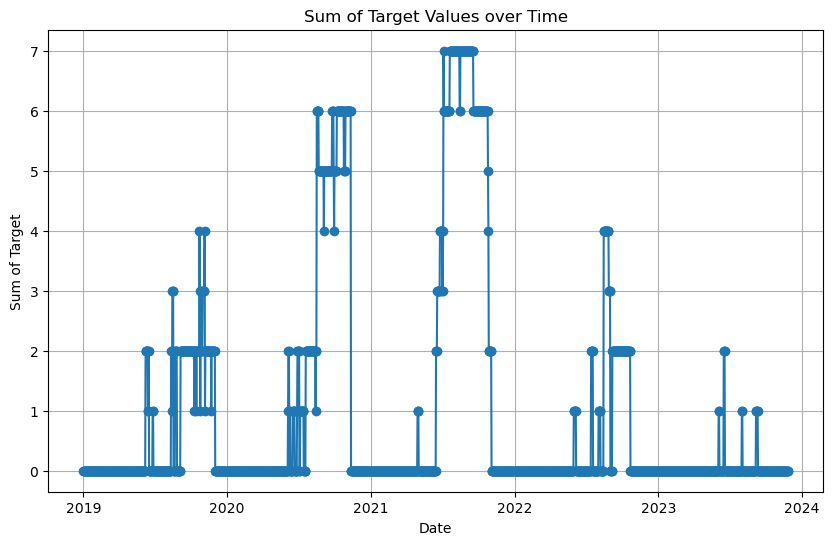

In [6]:
import matplotlib.pyplot as plt

# Convert 'date' column to datetime if needed
data['date'] = pd.to_datetime(data['date'])

# Group by 'date' and sum the 'target' column
date_sum = data.groupby('date')['target'].sum()

# Plotting the data
plt.figure(figsize=(10, 6))
plt.plot(date_sum.index, date_sum.values, marker='o', linestyle='-')
plt.xlabel('Date')
plt.ylabel('Sum of Target')
plt.title('Sum of Target Values over Time')
plt.grid(True)
plt.show()


# Finding: Sensors have some corrupt values that affect Model Results: Imputation Needed

## Pre Imputation Example

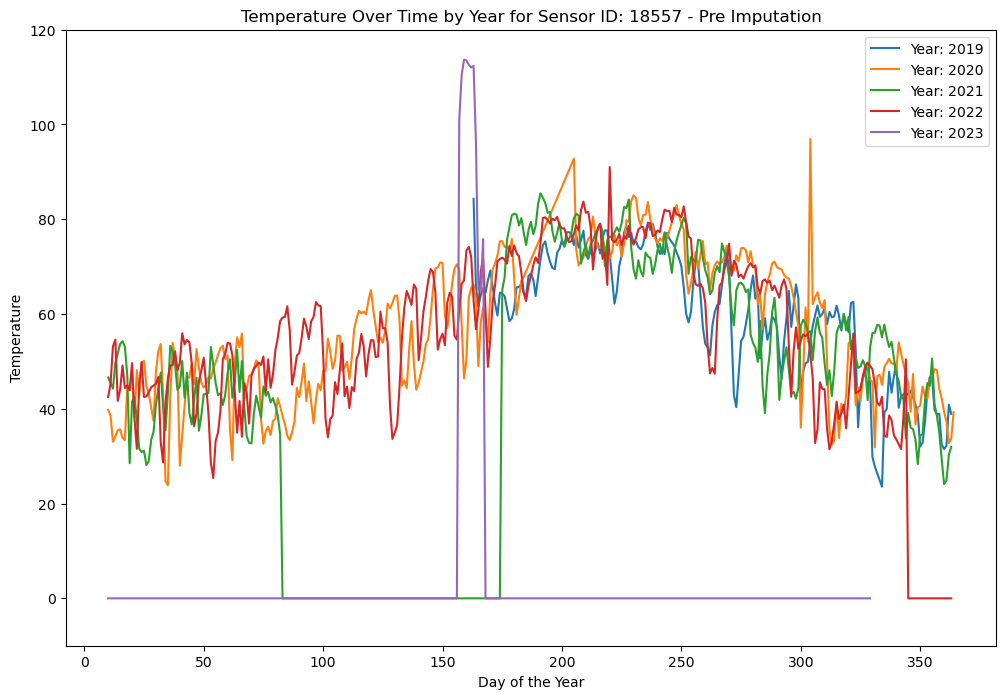

In [7]:
sensor_pre_imputation = data[data['sensor_id'] == 18557]
years = sensor_pre_imputation['year'].unique()

plt.figure(figsize=(12, 8))
# Loop through each year and plot
for year in years:
    yearly_data = sensor_pre_imputation[sensor_pre_imputation['year'] == year]
    plt.plot(yearly_data['day_of_year'], yearly_data['temperature'], label=f'Year: {year}')

plt.xlabel('Day of the Year')
plt.ylabel('Temperature')
plt.title('Temperature Over Time by Year for Sensor ID: 18557 - Pre Imputation')
plt.ylim(-10, 120)
plt.legend()
plt.show()

## Imputation Pipeline

In [8]:
# For temperature and pressure
data_missing = data[data['temperature'] == 0]
data_nonmissing = data[data['temperature'] != 0]
df_impute= data_nonmissing.groupby(['sensor_id', 'day_of_year'])['temperature'].mean().reset_index()

df_impute = df_impute.rename(columns = {'temperature' : 'imputed'})

data_missing = data_missing.merge(df_impute, how = 'left', on = ['sensor_id', 'day_of_year'])
data_missing['temperature'] = data_missing['imputed']
data_missing = data_missing.drop(columns = ['imputed'])

merged = pd.concat([data_nonmissing, data_missing], axis = 0)

data_missing = merged[merged['pressure'] == 0]
data_nonmissing = merged[merged['pressure'] != 0]
df_impute= data_nonmissing.groupby(['sensor_id', 'day_of_year'])['pressure'].mean().reset_index()

df_impute = df_impute.rename(columns = {'pressure' : 'imputed'})

data_missing = data_missing.merge(df_impute, how = 'left', on = ['sensor_id', 'day_of_year'])
data_missing['pressure'] = data_missing['imputed']
data_missing = data_missing.drop(columns = ['imputed'])

data = pd.concat([data_nonmissing, data_missing], axis = 0)
data = data.sort_values(['sensor_id','year','day_of_year'],ascending=True)
data.head()

,date,humidity,temperature,pressure,pm2.5_alt,scattering_coefficient,visual_range,0.3_um_count,5.0_um_count,pm1.0_atm,...,tavg,tmin,tmax,prcp,wspd,list_of_rel_direction,target,log_0.3_um_count,year,day_of_year
5348,2019-01-10,66.897,56.475,965.013,1.9,5.8,230.7,383.4190,1.3860,1.2355,...,10.6,8.3,15.6,0.0,4.1,NaN,0,5.951733,2019,10
5120,2019-01-11,61.062,55.455,959.487,1.9,7.0,212.2,465.5915,0.9025,1.7580,...,9.8,6.7,12.2,0.0,3.6,NaN,0,6.145454,2019,11
5321,2019-01-12,59.698,58.520,957.967,2.5,9.5,182.5,631.7450,0.6640,2.6995,...,11.0,7.8,17.8,0.0,4.3,NaN,0,6.450067,2019,12
5332,2019-01-13,52.364,58.599,960.322,4.6,17.0,128.3,1132.7715,0.9130,5.7080,...,9.4,4.4,16.7,0.0,4.6,NaN,0,7.033305,2019,13
5187,2019-01-14,39.537,58.244,957.313,1.4,6.0,227.0,398.7410,0.3995,1.2000,...,8.5,3.9,14.4,0.0,9.0,NaN,0,5.990817,2019,14


## Post Imputation Example

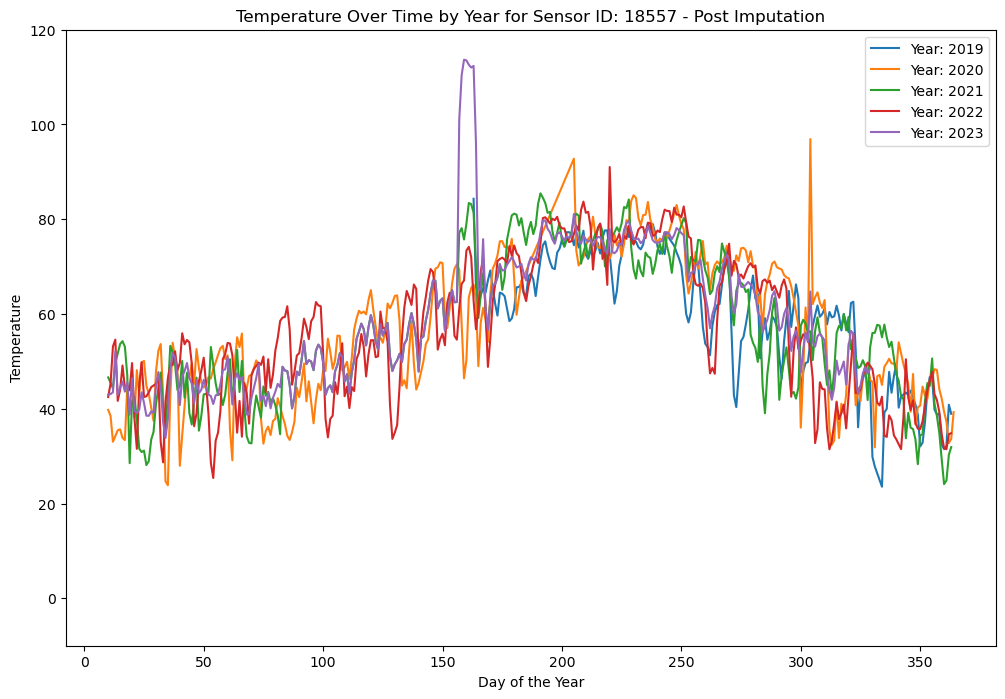

In [9]:
sensor_post_imputation = data[data['sensor_id'] == 18557]

plt.figure(figsize=(12, 8))

# Loop through each year and plot
for year in years:
    yearly_data = sensor_post_imputation[sensor_post_imputation['year'] == year]
    plt.plot(yearly_data['day_of_year'], yearly_data['temperature'], label=f'Year: {year}')

plt.xlabel('Day of the Year')
plt.ylabel('Temperature')
plt.title('Temperature Over Time by Year for Sensor ID: 18557 - Post Imputation')
plt.ylim(-10,120)
plt.legend()
plt.show()

# Class Imbalance over time

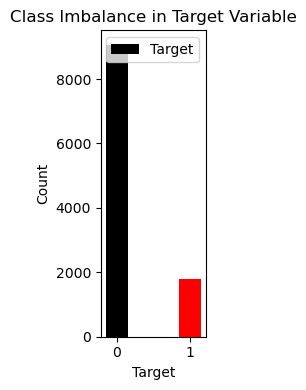

In [36]:
import matplotlib.pyplot as plt

# Count occurrences of each target
target_counts = data['target'].value_counts()

# Plotting the bar chart
targets = target_counts.index
bar_width = 0.3  # Decreased bar width
index = range(len(targets))

plt.figure(figsize=(2, 4))

plt.bar(index, target_counts, bar_width, label='Target', color=['black', 'red'])

plt.xlabel('Target')
plt.ylabel('Count')
plt.title('Class Imbalance in Target Variable')
plt.xticks(index, targets)
plt.legend()

plt.tight_layout()
plt.show()


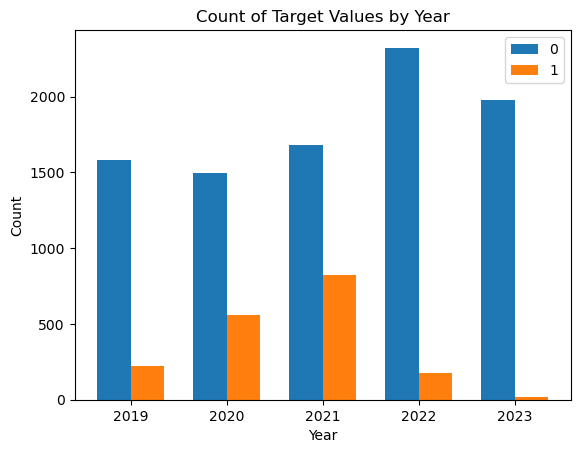

In [10]:
import matplotlib.pyplot as plt

# Group by 'year' and 'target', and count occurrences
yearly_counts = data.groupby(['year', 'target']).size().unstack(fill_value=0)

# Plotting the bar chart
years = yearly_counts.index
targets = [0, 1]
bar_width = 0.35
index = range(len(years))

fig, ax = plt.subplots()
for i, target in enumerate(targets):
    ax.bar([x + i * bar_width for x in index], yearly_counts[target], bar_width, label=target)

ax.set_xlabel('Year')
ax.set_ylabel('Count')
ax.set_title('Count of Target Values by Year')
ax.set_xticks([x + bar_width / 2 for x in index])
ax.set_xticklabels(years)
ax.legend()

plt.show()


# Pipeline to Train 3 Models with 2 Experiment Setups

## Preprocessing

In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler

def preprocess_data(data):
    # Convert 'date' column to datetime and extract month
    data['month'] = pd.to_datetime(data['date']).dt.month
    
    # Create dummy variables for month
    month_dummies = pd.get_dummies(data['month'], prefix='month').astype(int)
    data = pd.concat([data, month_dummies], axis=1)
    
    # Drop unnecessary columns
    data = data.drop(columns=['month', 'date', 'day_of_year','sensor_id']) 
    
    # Drop original object type columns
    data = data.select_dtypes(include=['number'])
    
    # Scale numerical features except 'target'
    scaler = StandardScaler()
    numerical_cols = data.select_dtypes(include=['int', 'float']).columns.drop('target')
    data[numerical_cols] = scaler.fit_transform(data[numerical_cols])
    
    unique_years = data['year'].unique()
    print("Unique years:", unique_years)
    
    print("Shape after Dummies")
    print(data.shape)
    print(data.dtypes)
    return data

def separate_blind_dataset(df):
    # scaled "years" : [-1.54040167 -0.79795459 -0.05550751  0.68693957  1.42938666]
    blind_set = df[df['year'] >= 1]
    print("Shape of blind test set:", blind_set.shape)
    return blind_set

def downsample_majority_class(data, minority_class_label='target', random_state=123):
    data_majority = data[data[minority_class_label] == 0]
    data_minority = data[data[minority_class_label] == 1]
    print("Shape of Minority Class")
    print(data_minority.shape)
    data_majority_downsampled = resample(data_majority, replace=False, n_samples=len(data_minority), random_state=random_state)
    return pd.concat([data_majority_downsampled, data_minority])

def random_over_sampling(X_train, y_train):
    ros = RandomOverSampler(random_state=123)
    X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)
    return X_train_resampled, y_train_resampled

## Models

In [12]:
def train_logistic_regression(X_train, y_train, param_grid):
    log_reg = LogisticRegression(random_state=123)
    grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring='f1')
    grid_search.fit(X_train, y_train)
    return grid_search.best_estimator_

def train_random_forest(X_train, y_train, param_grid):
    rf_clf = RandomForestClassifier(random_state=123)
    grid_search = GridSearchCV(rf_clf, param_grid, cv=5, scoring='f1')
    grid_search.fit(X_train, y_train)
    return grid_search.best_estimator_

def train_neural_network(X_train, y_train, param_grid):
    nn_clf = MLPClassifier(random_state=123)
    grid_search = GridSearchCV(nn_clf, param_grid, cv=5, scoring='f1')
    grid_search.fit(X_train, y_train)
    return grid_search.best_estimator_

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    metrics = {
        'confusion_matrix': confusion_matrix(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1_score': f1_score(y_test, y_pred),
        'accuracy': accuracy_score(y_test, y_pred)
    }
    return metrics

def evaluate_on_blind_set(model, blind_set, minority_class_label='target'):
    X_blind = blind_set.drop(columns=[minority_class_label])
    y_blind = blind_set[minority_class_label]
    
    evaluation_metrics = evaluate_model(model, X_blind, y_blind)
    
    return evaluation_metrics

def run_pipeline_undersampling(data, param_grids):
    preprocessed_data = preprocess_data(data)
    #blind_set = separate_blind_dataset(preprocessed_data, size=2000, stratify_col='target')
    blind_set = separate_blind_dataset(preprocessed_data)
    data_remaining = preprocessed_data.drop(blind_set.index)
    
    X = data_remaining.drop(columns=['target'])
    y = data_remaining['target']
    
    # X_train, X_test, y_train, y_test where test: year==2022
    # Filter the data based on the 'year' column
    # scaled "years" : [-1.54040167 -0.79795459 -0.05550751  0.68693957  1.42938666]
    X_test = X[X['year'] >= 0.5]
    X_train = X[X['year'] < 0.5]
    y_test = y[X['year'] >= 0.5]
    y_train = y[X['year'] < 0.5]

    print("Shape of X_train:", X_train.shape)
    print("Shape of X_test:", X_test.shape)
    print("Shape of y_train:", y_train.shape)
    print("Shape of y_test:", y_test.shape)
    
    downsampled_data = downsample_majority_class(pd.concat([X_train, y_train], axis=1))
    X_train_downsampled = downsampled_data.drop(columns=['target'])
    y_train_downsampled = downsampled_data['target']
    
    best_models = {}
    for clf_name, (train_fn, param_grid) in param_grids.items():
        best_model = train_fn(X_train_downsampled, y_train_downsampled, param_grid)
        best_models[clf_name] = best_model
        
        # Print the best parameters for the current model
        if isinstance(best_model, GridSearchCV):
            print(f"Best parameters for {clf_name}: {best_model.best_params_}")
        else:
            print(f"Best parameters for {clf_name}: {best_model.get_params()}")
        
    return X_train, X_test, y_test, blind_set, best_models

def run_pipeline_smote(data, param_grids):
    preprocessed_data = preprocess_data(data)
    # blind_set = separate_blind_dataset(preprocessed_data, size=2000, stratify_col='target')
    blind_set = separate_blind_dataset(preprocessed_data)
    
    data_remaining = preprocessed_data.drop(blind_set.index)
    
    X = data_remaining.drop(columns=['target'])
    y = data_remaining['target']
    
    #X_train, X_test, y_train, y_test where test: year==2022
    
    # Filter the data based on the 'year' column
    # scaled "years" : [-1.54040167 -0.79795459 -0.05550751  0.68693957  1.42938666]
    X_test = X[X['year'] >= 0.5]
    X_train = X[X['year'] < 0.5]
    y_test = y[X['year'] >= 0.5]
    y_train = y[X['year'] < 0.5]

    print("Shape of X_train:", X_train.shape)
    print("Shape of X_test:", X_test.shape)
    print("Shape of y_train:", y_train.shape)
    print("Shape of y_test:", y_test.shape)
    
    X_train_resampled, y_train_resampled = random_over_sampling(X_train, y_train)
    
    best_models = {}
    for clf_name, (train_fn, param_grid) in param_grids.items():
        best_model = train_fn(X_train_resampled, y_train_resampled, param_grid)
        best_models[clf_name] = best_model
        
        # Print the best parameters for the current model
        if isinstance(best_model, GridSearchCV):
            print(f"Best parameters for {clf_name}: {best_model.best_params_}")
        else:
            print(f"Best parameters for {clf_name}: {best_model.get_params()}")
        
    return X_train, X_test, y_test, blind_set, best_models

## Run UNDERSAMPLING Pipeline

In [13]:
# Define parameter grids for hyperparameter tuning
param_grids = {
    'Logistic Regression': (train_logistic_regression, {'C': [0.001, 0.01, 0.1, 1, 10, 100]}),
    'Random Forest': (train_random_forest, {'n_estimators': [100], 'max_depth': [5,10,15,20], 'min_samples_leaf': [1, 5, 10, 20]}),
    'Neural Network': (train_neural_network, {'hidden_layer_sizes': [(20,), (30,),(50,), (20, 20),(50, 50),(20, 20, 20)], 'alpha': [0.0001, 0.001, 0.01]})
}

# Run the pipeline
X_train, X_test, y_test, blind_set, models_undersampling = run_pipeline_undersampling(data, param_grids)

Unique years: [-1.54040167 -0.79795459 -0.05550751  0.68693957  1.42938666]
Shape after Dummies
(10861, 33)
humidity                  float64
temperature               float64
pressure                  float64
pm2.5_alt                 float64
scattering_coefficient    float64
visual_range              float64
0.3_um_count              float64
5.0_um_count              float64
pm1.0_atm                 float64
pm2.5_atm                 float64
pm2.5_cf_1                float64
pm10.0_atm                float64
altitude                  float64
tavg                      float64
tmin                      float64
tmax                      float64
prcp                      float64
wspd                      float64
target                      int64
log_0.3_um_count          float64
year                      float64
month_1                   float64
month_2                   float64
month_3                   float64
month_4                   float64
month_5                   float64
month_6 

## Evaluate Undersampling Models on Test:

In [14]:
# Evaluate models on the test set
test_evaluation_results = {}
for clf_name, model in models_undersampling.items():
    test_evaluation_results[clf_name] = evaluate_model(model, X_test, y_test)

# Display evaluation metrics for the test set
for clf_name, evaluation_metrics in test_evaluation_results.items():
    print(f"Performance of {clf_name} on the Test Set:")
    print("Confusion Matrix:\n", evaluation_metrics['confusion_matrix'])
    print("Precision: {:.2f}".format(evaluation_metrics['precision']))
    print("Recall: {:.2f}".format(evaluation_metrics['recall']))
    print("F1 Score: {:.2f}".format(evaluation_metrics['f1_score']))
    print("Accuracy: {:.2f}".format(evaluation_metrics['accuracy']))
    print()


Performance of Logistic Regression on the Test Set:
Confusion Matrix:
 [[1282 1041]
 [   4  173]]
Precision: 0.14
Recall: 0.98
F1 Score: 0.25
Accuracy: 0.58

Performance of Random Forest on the Test Set:
Confusion Matrix:
 [[1589  734]
 [  24  153]]
Precision: 0.17
Recall: 0.86
F1 Score: 0.29
Accuracy: 0.70

Performance of Neural Network on the Test Set:
Confusion Matrix:
 [[1578  745]
 [  23  154]]
Precision: 0.17
Recall: 0.87
F1 Score: 0.29
Accuracy: 0.69



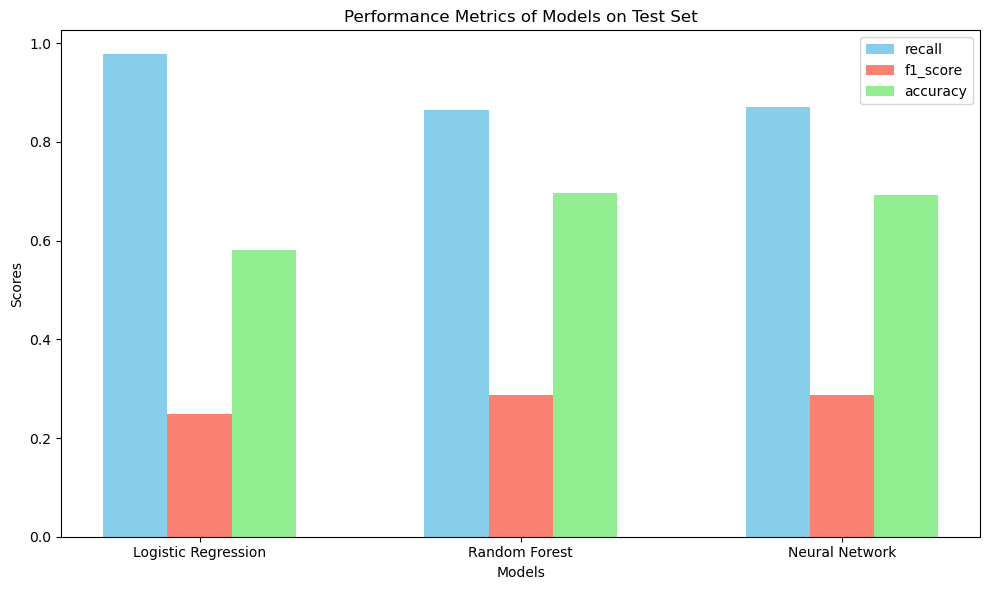

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Define model names and corresponding metric values
model_names = list(test_evaluation_results.keys())
metrics = ['recall', 'f1_score', 'accuracy']
metric_values = {metric: [test_evaluation_results[model][metric.lower()] for model in model_names] for metric in metrics}

# Define colors for each metric
colors = ['skyblue', 'salmon', 'lightgreen']

# Create bar chart
bar_width = 0.2
index = np.arange(len(model_names))

plt.figure(figsize=(10, 6))

for i, metric in enumerate(metrics):
    plt.bar(index + i * bar_width, metric_values[metric], bar_width, label=metric, color=colors[i])

plt.xlabel('Models')
plt.ylabel('Scores')
plt.title('Performance Metrics of Models on Test Set')
plt.xticks(index + bar_width, model_names)
plt.legend()

plt.tight_layout()
plt.show()


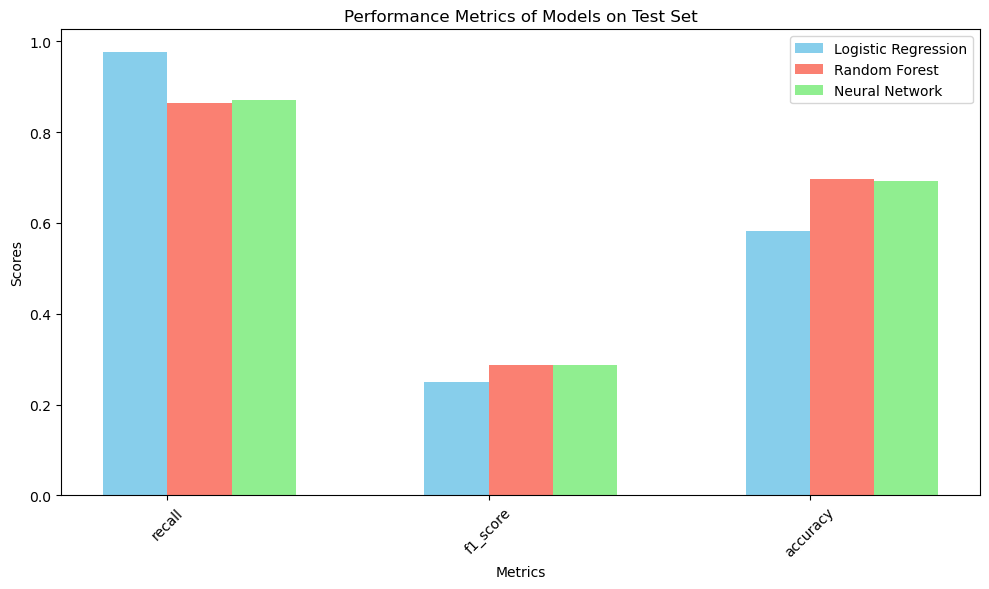

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Define model names and corresponding metric values
model_names = list(test_evaluation_results.keys())
metrics = ['recall', 'f1_score', 'accuracy']
metric_values = {metric: [test_evaluation_results[model][metric.lower()] for model in model_names] for metric in metrics}

# Define colors for each model
colors = ['skyblue', 'salmon', 'lightgreen']

# Create color dictionary mapping each model to a color
model_colors = {model: color for model, color in zip(model_names, colors)}

# Create bar chart
bar_width = 0.2
index = np.arange(len(metrics))

plt.figure(figsize=(10, 6))

for i, model in enumerate(model_names):
    model_metric_values = [test_evaluation_results[model][metric.lower()] for metric in metrics]
    plt.bar(index + i * bar_width, model_metric_values, bar_width, label=model, color=model_colors[model])

plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.title('Performance Metrics of Models on Test Set')
plt.xticks(index + 0.5 * bar_width, metrics)
plt.legend(loc='upper right')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


## Feature Importance for Undersampling Models

In [21]:
models_undersampling

{'Logistic Regression': LogisticRegression(C=0.1, random_state=123),
 'Random Forest': RandomForestClassifier(max_depth=20, min_samples_leaf=5, random_state=123),
 'Neural Network': MLPClassifier(alpha=0.01, hidden_layer_sizes=(30,), random_state=123)}

In [22]:

rf_model = models_undersampling['Random Forest']

# Get feature names
feature_names = X_train.columns

# Get feature importances
feature_importances = rf_model.feature_importances_

# Combine feature names and importances
features_and_importances = zip(feature_names, feature_importances)

# Sorting the features by importance
sorted_features_and_importances = sorted(features_and_importances, key=lambda x: x[1], reverse=True)

# Printing the sorted features and their importances
for feature, importance in sorted_features_and_importances:
    print(f"{feature}: {importance}")


month_10: 0.10868467595437804
tavg: 0.09364988933312565
temperature: 0.09332134458542206
tmax: 0.08011068812137323
pressure: 0.05006300662252992
pm2.5_alt: 0.04897166187293556
year: 0.043517110503244597
humidity: 0.04146737095104709
tmin: 0.03395010462246099
month_5: 0.0339500504271894
pm2.5_atm: 0.032346173046743164
month_9: 0.031689213669112495
visual_range: 0.028787514358277717
log_0.3_um_count: 0.026684909371620123
0.3_um_count: 0.02580179363501315
pm10.0_atm: 0.025177332241592444
scattering_coefficient: 0.02158768906021058
month_4: 0.021503487618552013
altitude: 0.021183274615460754
pm2.5_cf_1: 0.020721089592852317
pm1.0_atm: 0.020124740180153724
wspd: 0.01925670055735636
5.0_um_count: 0.016543853033394618
month_11: 0.013957217908744947
month_6: 0.010572364678539722
month_7: 0.007171195746755788
month_3: 0.006305614394215364
month_12: 0.0062478222231097825
month_1: 0.006046745827635243
month_8: 0.004799659421802575
month_2: 0.0040067041388017
prcp: 0.0017990016863487846


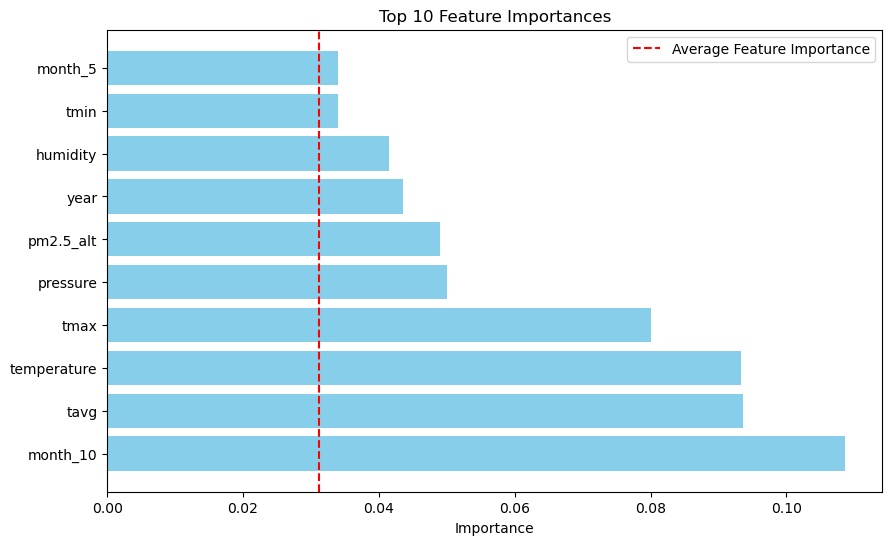

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# Get the top 10 features and their importances
top_features = sorted_features_and_importances[:10]
top_feature_names, top_importances = zip(*top_features)

# Calculate the average importance of all features
average_importance = np.mean(feature_importances)

# Plotting
plt.figure(figsize=(10, 6))

# Plot the top 10 features
plt.barh(np.arange(len(top_feature_names)), top_importances, align='center', color='skyblue')
plt.yticks(np.arange(len(top_feature_names)), top_feature_names)
plt.xlabel('Importance')
plt.title('Top 10 Feature Importances')

# Plot the average line
plt.axvline(x=average_importance, color='red', linestyle='--', label='Average Feature Importance')
plt.legend()

plt.show()

# Train 3 Models with CV on Imputed Data (Oversampling)

## Run Oversampling Pipeline

In [25]:
# Run the pipeline
X_train, X_test, y_test, blind_set, models_smote = run_pipeline_smote(data, param_grids)

Unique years: [-1.54040167 -0.79795459 -0.05550751  0.68693957  1.42938666]
Shape after Dummies
(10861, 33)
humidity                  float64
temperature               float64
pressure                  float64
pm2.5_alt                 float64
scattering_coefficient    float64
visual_range              float64
0.3_um_count              float64
5.0_um_count              float64
pm1.0_atm                 float64
pm2.5_atm                 float64
pm2.5_cf_1                float64
pm10.0_atm                float64
altitude                  float64
tavg                      float64
tmin                      float64
tmax                      float64
prcp                      float64
wspd                      float64
target                      int64
log_0.3_um_count          float64
year                      float64
month_1                   float64
month_2                   float64
month_3                   float64
month_4                   float64
month_5                   float64
month_6 

## Evaluate Oversampling Models on Test

In [26]:
# Evaluate models on the test set
test_evaluation_results = {}
for clf_name, model in models_smote.items():
    test_evaluation_results[clf_name] = evaluate_model(model, X_test, y_test)

# Display evaluation metrics for the test set
for clf_name, evaluation_metrics in test_evaluation_results.items():
    print(f"Performance of {clf_name} on the Test Set:")
    print("Confusion Matrix:\n", evaluation_metrics['confusion_matrix'])
    print("Precision: {:.2f}".format(evaluation_metrics['precision']))
    print("Recall: {:.2f}".format(evaluation_metrics['recall']))
    print("F1 Score: {:.2f}".format(evaluation_metrics['f1_score']))
    print("Accuracy: {:.2f}".format(evaluation_metrics['accuracy']))
    print()

Performance of Logistic Regression on the Test Set:
Confusion Matrix:
 [[1269 1054]
 [   4  173]]
Precision: 0.14
Recall: 0.98
F1 Score: 0.25
Accuracy: 0.58

Performance of Random Forest on the Test Set:
Confusion Matrix:
 [[1686  637]
 [  26  151]]
Precision: 0.19
Recall: 0.85
F1 Score: 0.31
Accuracy: 0.73

Performance of Neural Network on the Test Set:
Confusion Matrix:
 [[1784  539]
 [  30  147]]
Precision: 0.21
Recall: 0.83
F1 Score: 0.34
Accuracy: 0.77



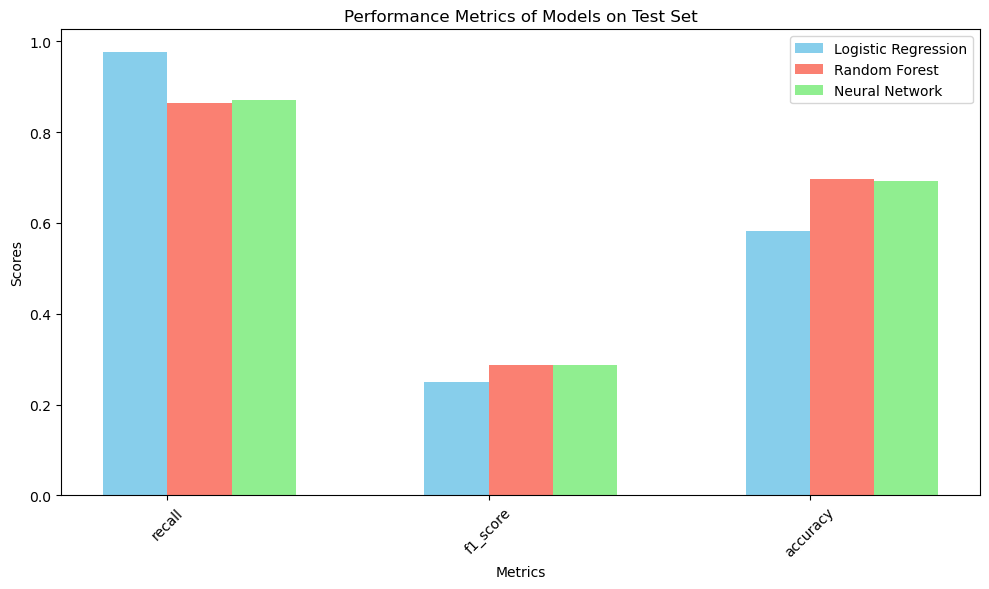

In [28]:
import matplotlib.pyplot as plt
import numpy as np

# Define model names and corresponding metric values
model_names = list(test_evaluation_results.keys())
metrics = ['recall', 'f1_score', 'accuracy']
metric_values = {metric: [test_evaluation_results[model][metric.lower()] for model in model_names] for metric in metrics}

# Define colors for each model
colors = ['skyblue', 'salmon', 'lightgreen']

# Create color dictionary mapping each model to a color
model_colors = {model: color for model, color in zip(model_names, colors)}

# Create bar chart
bar_width = 0.2
index = np.arange(len(metrics))

plt.figure(figsize=(10, 6))

for i, model in enumerate(model_names):
    model_metric_values = [test_evaluation_results[model][metric.lower()] for metric in metrics]
    plt.bar(index + i * bar_width, model_metric_values, bar_width, label=model, color=model_colors[model])

plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.title('Performance Metrics of Models on Test Set')
plt.xticks(index + 0.5 * bar_width, metrics)
plt.legend(loc='upper right')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


## Print Feature Evaluation on Oversampling

In [29]:

rf_model = models_undersampling['Random Forest']

# Get feature names
feature_names = X_train.columns

# Get feature importances
feature_importances = rf_model.feature_importances_

# Combine feature names and importances
features_and_importances = zip(feature_names, feature_importances)

# Sorting the features by importance
sorted_features_and_importances = sorted(features_and_importances, key=lambda x: x[1], reverse=True)

# Printing the sorted features and their importances
for feature, importance in sorted_features_and_importances:
    print(f"{feature}: {importance}")


month_10: 0.10868467595437804
tavg: 0.09364988933312565
temperature: 0.09332134458542206
tmax: 0.08011068812137323
pressure: 0.05006300662252992
pm2.5_alt: 0.04897166187293556
year: 0.043517110503244597
humidity: 0.04146737095104709
tmin: 0.03395010462246099
month_5: 0.0339500504271894
pm2.5_atm: 0.032346173046743164
month_9: 0.031689213669112495
visual_range: 0.028787514358277717
log_0.3_um_count: 0.026684909371620123
0.3_um_count: 0.02580179363501315
pm10.0_atm: 0.025177332241592444
scattering_coefficient: 0.02158768906021058
month_4: 0.021503487618552013
altitude: 0.021183274615460754
pm2.5_cf_1: 0.020721089592852317
pm1.0_atm: 0.020124740180153724
wspd: 0.01925670055735636
5.0_um_count: 0.016543853033394618
month_11: 0.013957217908744947
month_6: 0.010572364678539722
month_7: 0.007171195746755788
month_3: 0.006305614394215364
month_12: 0.0062478222231097825
month_1: 0.006046745827635243
month_8: 0.004799659421802575
month_2: 0.0040067041388017
prcp: 0.0017990016863487846


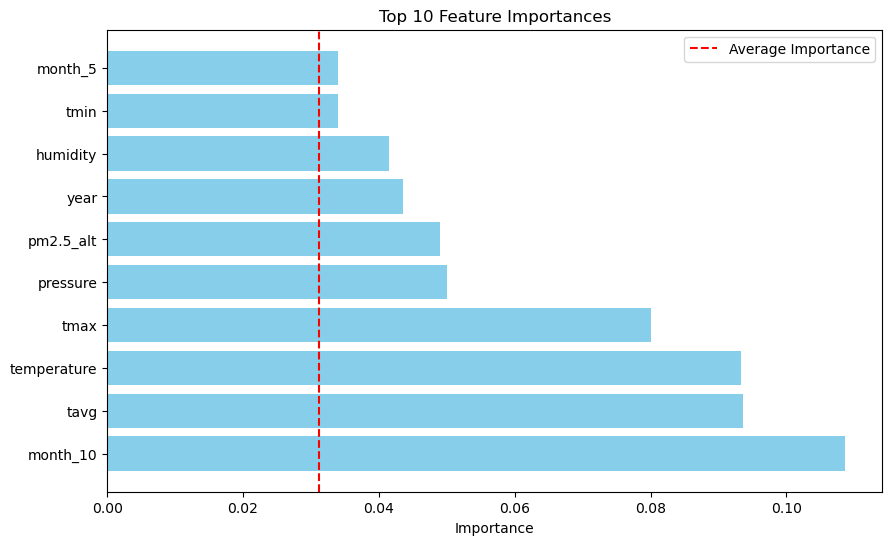

In [30]:
import matplotlib.pyplot as plt
import numpy as np

# Get the top 10 features and their importances
top_features = sorted_features_and_importances[:10]
top_feature_names, top_importances = zip(*top_features)

# Calculate the average importance of all features
average_importance = np.mean(feature_importances)

# Plotting
plt.figure(figsize=(10, 6))

# Plot the top 10 features
plt.barh(np.arange(len(top_feature_names)), top_importances, align='center', color='skyblue')
plt.yticks(np.arange(len(top_feature_names)), top_feature_names)
plt.xlabel('Importance')
plt.title('Top 10 Feature Importances')

# Plot the average line
plt.axvline(x=average_importance, color='red', linestyle='--', label='Average Importance')
plt.legend()

plt.show()

# Evaluate on Blind

In [ ]:
# Evaluate undersampling models on the blind test set
blind_evaluation_results = {}
for clf_name, model in models_undersampling.items():
    blind_evaluation_results[clf_name] = evaluate_on_blind_set(model, blind_set)

# Display evaluation metrics for the blind test set
for clf_name, evaluation_metrics in blind_evaluation_results.items():
    print(f"Performance of {clf_name} on the Blind Test Set:")
    print("Confusion Matrix:\n", evaluation_metrics['confusion_matrix'])
    print("Precision: {:.2f}".format(evaluation_metrics['precision']))
    print("Recall: {:.2f}".format(evaluation_metrics['recall']))
    print("F1 Score: {:.2f}".format(evaluation_metrics['f1_score']))
    print("Accuracy: {:.2f}".format(evaluation_metrics['accuracy']))
    print()

In [ ]:
# Evaluate undersampling models on the blind test set
blind_evaluation_results = {}
for clf_name, model in models_smote.items():
    blind_evaluation_results[clf_name] = evaluate_on_blind_set(model, blind_set)

# Display evaluation metrics for the blind test set
for clf_name, evaluation_metrics in blind_evaluation_results.items():
    print(f"Performance of {clf_name} on the Blind Test Set:")
    print("Confusion Matrix:\n", evaluation_metrics['confusion_matrix'])
    print("Precision: {:.2f}".format(evaluation_metrics['precision']))
    print("Recall: {:.2f}".format(evaluation_metrics['recall']))
    print("F1 Score: {:.2f}".format(evaluation_metrics['f1_score']))
    print("Accuracy: {:.2f}".format(evaluation_metrics['accuracy']))
    print()

# NEXT STEPS: Include Gradient Boosting Tree above

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

# Initialize the Gradient Boosting Classifier model
gradient_boost = GradientBoostingClassifier(random_state = 42)

# Fit the model on the training data
gradient_boost.fit(X_train_downsample, y_train_downsample)

# Make predictions on the test set
y_pred = gradient_boost.predict(X_test)

# NEXT STEPS: Try PCA if we want (maybe helps not to overfit)